In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
import scienceplots

plt.style.use(['science', 'bright', 'vpedre'])

In [2]:
# deltalna = 7.5e-4
# lna_start = -5
# lna_end = 0.25
# N = int((lna_end - lna_start) / deltalna) + 1

# lna_smg =   np.linspace(lna_start, lna_end, N)
# DeltaM2 =   np.linspace(1e-4, 1e-4, N)
# Dkin =      np.linspace(1e-4, 1e-4, N)
# cs2 =       np.linspace(1., 1., N)

# # Stack the arrays column-wise and save
# data = np.column_stack((lna_smg, DeltaM2, Dkin, cs2))
# np.savetxt("../stable_params_input/gr.dat", data, delimiter=" ")

In [3]:
kk = np.geomspace(1e-4, 10, num=3)

In [10]:
gral_pars = {
    # Reference Cosmology from EuclidEmuII
    'H0'      : 67,
    'Omega_b' : 0.049,
    'Omega_cdm' : 0.27,

    'A_s' : 2.1e-9,
    'n_s' : 0.96,
    'alpha_s' : 0,
    'k_pivot' : 0.05,

    'evolver': 0,
    'output':'tCl mPk dTk vTk',
    'z_max_pk': 3,
    'k_output_values': ','.join([str(k) for k in kk])
}

w0wa_class = gral_pars | {
    # MG MODEL
    # Disable cosmological constant 
    'Omega_Lambda': 0,
    # Dark energy fluid parameters
    'w0_fld' : -1.,
    'wa_fld' : 0.,
    'cs2_fld':1.,
    # 'root': 'output/w0wa_class',
}

w0wa_mochi = gral_pars | {
    # MG MODEL
    # Disable cosmological constant and DE fluid
    'Omega_Lambda': 0,
    'Omega_fld': 0,
    # Enable mochiclass
    'Omega_smg': -1,
    # Choose the model
    'root': 'output/w0wa_mochi',
    'gravity_model': 'stable_params',
    'smg_file_name': '../stable_params_input/gr.dat',
    'parameters_smg': '1e-6',
    'expansion_model': 'w0wa',
    'expansion_smg': '0.67, -1., 0.', #Lambda, w0, wa
    # CLASS evolver
    'method_qs_smg': 'fully_dynamic',
    'method_gr_smg': 'on'
}

hs_pars = gral_pars | {
    # MG MODEL
    # Disable cosmological constant and DE fluid
    'Omega_Lambda': 0,
    'Omega_fld': 0,
    # Enable mochiclass
    'Omega_smg': -1,
    # Choose the model
    'gravity_model': 'stable_params',
    'smg_file_name': '../stable_params_input/hs_fr_stable_params_fr0_1em4_n_1_mathematica.dat',
    'parameters_smg': '6.061178756035e-5',
    'expansion_model': 'rho_de',
    'expansion_smg': 0.5, #this value will be overwritten using the closure equation.
    'expansion_file_name' : '../stable_params_input/rho_de_stable_hs_fr_n_1_fr0_1em4_mathematica.dat',
    # CLASS evolver
    'method_qs_smg': 'fully_dynamic',
    'method_gr_smg': 'on'
}


In [11]:
cosmologies = {}

cosmologies['lcdm'] = Class()
cosmologies['lcdm'].set(gral_pars)
cosmologies['lcdm'].compute()
lcdm_bk, lcdm_pt = cosmologies['lcdm'].get_background(), cosmologies['lcdm'].get_perturbations()['scalar']

cosmologies['w0wa_class'] = Class()
cosmologies['w0wa_class'].set(w0wa_class)
cosmologies['w0wa_class'].compute()
w0wac_bk, w0wac_pt = cosmologies['w0wa_class'].get_background(), cosmologies['w0wa_class'].get_perturbations()['scalar']

cosmologies['w0wa_mochi'] = Class()
cosmologies['w0wa_mochi'].set(w0wa_mochi)
cosmologies['w0wa_mochi'].compute()
w0wac_bk, w0wac_pt = cosmologies['w0wa_mochi'].get_background(), ''#, cosmologies['w0wa_class'].get_perturbations()['scalar']


CosmoComputationError: 

Error in Class: operator()(L:946) :error in perturbations_solve(ppr, pba, pth, ppt, index_md, index_ic, index_k, &pw);
=>perturbations_solve(L:3313) :error in generic_evolver(perturbations_derivs, interval_limit[index_interval], interval_limit[index_interval+1], ppw->pv->y, ppw->pv->used_in_sources, ppw->pv->pt_size, &ppaw, ppr->tol_perturbations_integration, ppr->smallest_allowed_variation, perturbations_timescale, ppr->perturbations_integration_stepsize, ppt->tau_sampling, tau_actual_size, perturbations_sources, perhaps_print_variables, ppt->error_message);
=>evolver_rk(L:117) :error in generic_integrator(derivs, x1, x2, y, parameters_and_workspace_for_derivs, tolerance, x1*minimum_variation, &gi);
=>generic_integrator(L:127) :error; Too many integration steps needed within interval [86.9846 : 125.19],
 the system of equations is probably buggy or featuring a discontinuity

In [6]:
lcdm_bk_a = 1/(1+lcdm_bk['z'])
w0wac_bk_a= 1/(1+w0wac_bk['z'])
w0wam_bk_a= 1/(1+w0wam_bk['z'])

NameError: name 'w0wac_bk' is not defined

In [ ]:
w0wac_bk.keys()

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_fld', '(.)w_fld', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f', 'gr.fac. D2', 'gr.fac. f2', 'gr.fac. D3a', 'gr.fac. f3a', 'gr.fac. D3b', 'gr.fac. f3b', 'gr.fac. D3c', 'gr.fac. f3c'])

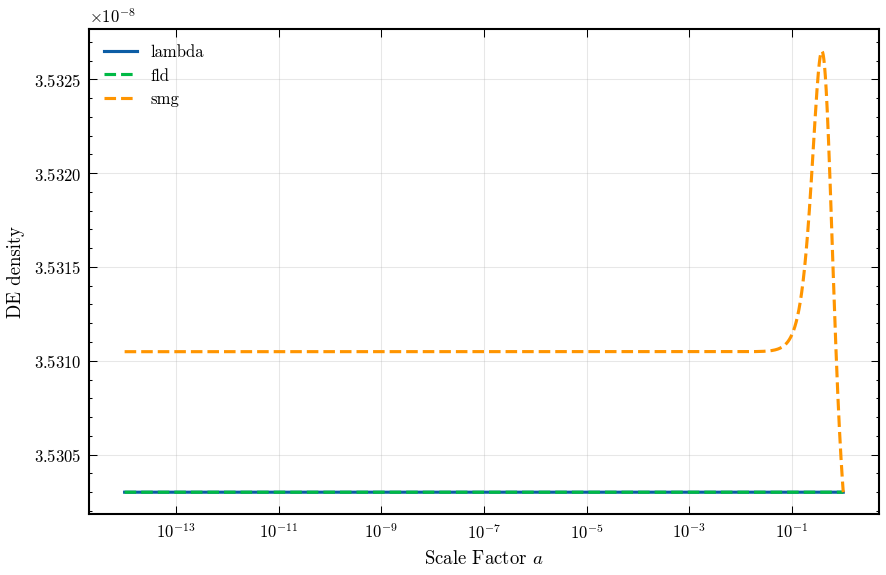

In [22]:
fig, ax = plt.subplots()

ax.semilogx(lcdm_bk_a, lcdm_bk['(.)rho_lambda'], label='lambda')
ax.semilogx(w0wac_bk_a, w0wac_bk['(.)rho_fld'], '--',label='fld')
ax.semilogx(w0wam_bk_a, w0wam_bk['(.)rho_smg'], '--',label='smg')

# ax.invert_xaxis()
ax.set_ylabel('DE density')
ax.set_xlabel('Scale Factor $a$')
ax.legend()


IndexError: string index out of range

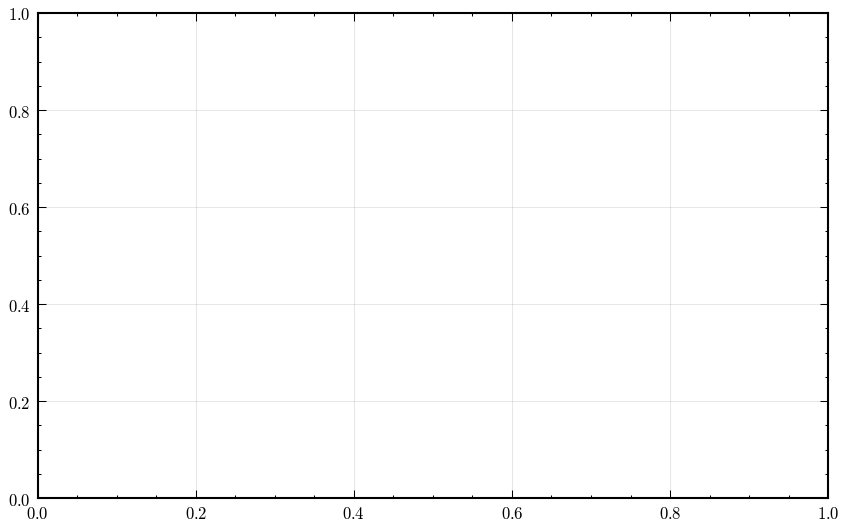

In [23]:
fig, ax = plt.subplots()

ax.semilogx(w0wac_pt[0]['a'], w0wac_pt[0]['delta_fld'])
ax.semilogx(w0wac_pt[0]['a'], w0wac_pt[0]['theta_fld'], '--')

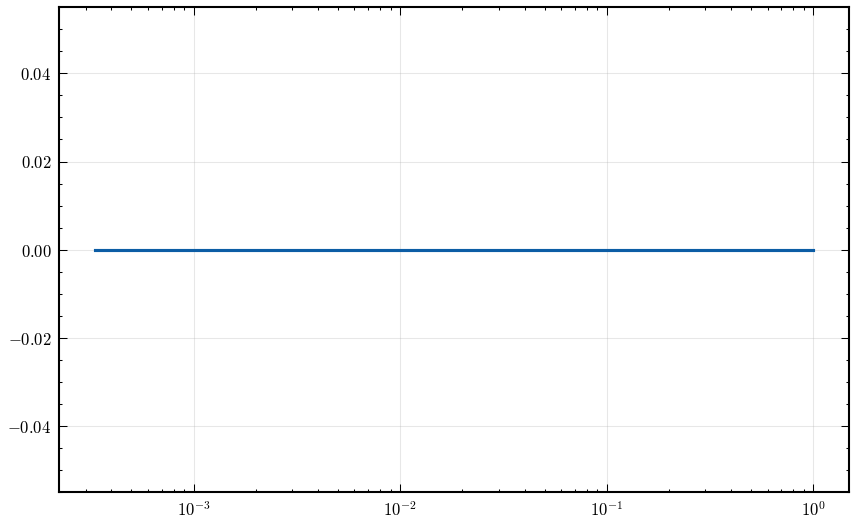

In [17]:
fig, ax = plt.subplots()

ax.semilogx(w0wac_pt[0]['a'], w0wac_pt[0]['theta_fld'])